<a href="https://colab.research.google.com/github/Preethana-c/AD_detection/blob/main/Yet_another_copy_of_AD_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sun Feb 23 18:15:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
pip install tensorflow==2.12.0

INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.0/586.0 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 MB 9.7 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninsta

In [ ]:
import tensorflow as tf
tf.__version__

'2.12.0'

In [ ]:
from tensorflow.keras.layers import Input,Lambda,Dense,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Define image size
IMAGE_SIZE = [224, 224]
BATCH_SIZE = 32
EPOCHS = 20  # Increase epochs for better training

# Define dataset path
dataset_path = '/content/drive/MyDrive/newslices'

# Create an ImageDataGenerator with more augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,  # Rotate images randomly
    width_shift_range=0.2,  # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],  # Adjust brightness
    fill_mode='nearest',
    validation_split=0.2
)



In [ ]:
# Load training data
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

Found 512 images belonging to 3 classes.


In [ ]:
# Load validation data
valid_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 127 images belonging to 3 classes.


In [ ]:
# Load pre-trained InceptionV3 model
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Unfreeze last few layers for fine-tuning
for layer in inception.layers[:-30]:  # Unfreezing last 30 layers
    layer.trainable = True

In [ ]:
# Add classification layers
x = GlobalAveragePooling2D()(inception.output)  # Better than Flatten()
x = Dense(512, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Dropout to prevent overfitting
x = Dense(256, activation='relu')(x)  # More layers for better feature extraction
x = Dropout(0.3)(x)
prediction = Dense(train_generator.num_classes, activation='softmax')(x)


In [ ]:
# Create the model
model = Model(inputs=inception.input, outputs=prediction)

In [ ]:
# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower LR for better fine-tuning
    metrics=['accuracy']
)

In [ ]:
# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower LR for better fine-tuning
    metrics=['accuracy']
)

In [ ]:
r = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS,
    steps_per_epoch=len(train_generator),
    validation_steps=len(valid_generator)
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 272s 12s/step - accuracy: 0.3951 - loss: 1.1522 - val_accuracy: 0.4803 - val_loss: 1.1369
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 661ms/step - accuracy: 0.4912 - loss: 1.0527 - val_accuracy: 0.4882 - val_loss: 1.1309
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 712ms/step - accuracy: 0.4009 - loss: 1.1349 - val_accuracy: 0.4803 - val_loss: 1.1905
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 722ms/step - accuracy: 0.4781 - loss: 1.0545 - val_accuracy: 0.4803 - val_loss: 1.0999
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 736ms/step - accuracy: 0.4711 - loss: 1.0685 - val_accuracy: 0.4803 - val_loss: 1.0757
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 719ms/step - accuracy: 0.4426 - loss: 1.0714 - val_accuracy: 0.4803 - val_loss: 1.0918
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 729ms/step - accuracy: 0.4778 - loss: 1.0659 - val_accuracy: 0.4882 - val_loss: 1.0587
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 713ms/step - accuracy: 0.4508 - loss: 1.0604 - val_accur

In [ ]:
model.save("inception_model.keras")  # New recommended format


In [ ]:
# Print model summary
model.summary()

In [ ]:

import matplotlib.pyplot as plt

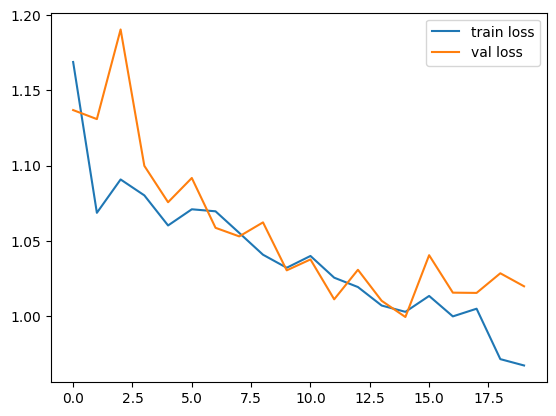

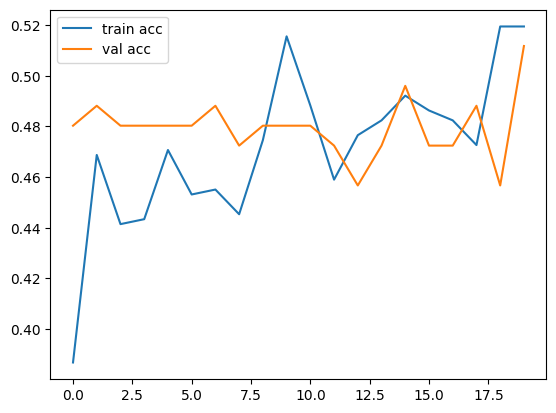

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os

# Load the trained model
model = tf.keras.models.load_model("inception_model.keras")


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 196 variables whereas the saved optimizer has 390 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Define the class labels (Ensure this matches your dataset folder structure)
class_labels = sorted(os.listdir('/content/drive/MyDrive/newslices'))  # Gets class names from folders
print("Class Labels:", class_labels)

Class Labels: ['AD', 'CN', 'MCI']


In [ ]:
def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)  # Load and resize image
    img_array = image.img_to_array(img)  # Convert to array
    img_array = img_array / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

In [ ]:
# Function to make predictions
def predict_image(img_path):
    img_array = preprocess_image(img_path)

    predictions = model.predict(img_array)  # Get prediction probabilities
    predicted_class_index = np.argmax(predictions)  # Get index of highest probability class
    predicted_class = class_labels[predicted_class_index]  # Get class name
    confidence = predictions[0][predicted_class_index] * 100  # Get confidence score

    # Display image with prediction
    plt.imshow(image.load_img(img_path))
    plt.title(f"Predicted: {predicted_class} ({confidence:.2f}%)")
    plt.axis("off")
    plt.show()

    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


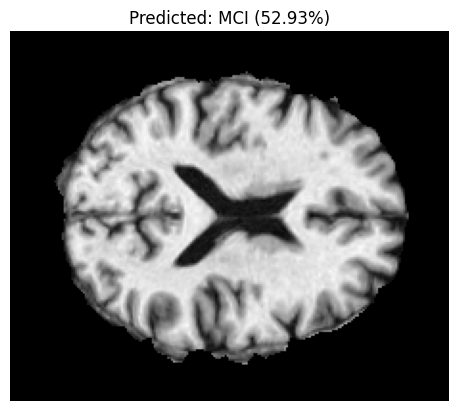

Prediction: MCI, Confidence: 52.93%


In [ ]:
# Example usage (Provide image path)
img_path = "/content/drive/MyDrive/newslices/AD/023_S_0084.png"  # Change to your image path
predicted_class, confidence = predict_image(img_path)
print(f"Prediction: {predicted_class}, Confidence: {confidence:.2f}%")

In [ ]:
# Evaluate the model on the validation set
loss, accuracy = model.evaluate(valid_generator)

# Print accuracy
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.4734 - loss: 1.0120
Validation Accuracy: 50.39%


In [ ]:
train_loss, train_accuracy = model.evaluate(train_generator)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")


16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 602ms/step - accuracy: 0.5092 - loss: 0.9262
Training Accuracy: 50.00%
